# EELS SrFeO Project 
## RNN Autoencoder

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


#### Some resources to read on RNN Autoencoder

* <span style="color: red"> // put resources here // </span>

### Import Package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  
 
# Do other imports now...
import keras

from keras.models import Model
from keras.layers import Input, LSTM, Dense, LeakyReLU
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

Using TensorFlow backend.


In [4]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
# checking device (GPU & CPU)
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11403241327048563548
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8816593944878663592
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10752973210
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5333518646447261958
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:05:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1977095451107978640
physical_device_desc: "device: XLA_GPU device"
]


## Load Data

In [61]:
#data = hs.load("processed_data/EELS_raw_*.hdf5")
import pickle
class Container(object): pass
temporal_data = list()
for k in range(48):
    f = pickle.load(open("processed_data/EELS_o_range_"+str(k)+".pkl", 'rb'))
    temporal_data.append(f)

In [62]:
temporal_data[0].O_range.shape

(36, 114, 60)

## Applying RNN Autoencoder to temporal data

### Downsampling

Done to reduce data size.

#### Resources
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean

In [63]:
from scipy.signal import resample
import itertools

def downsample(stacked_data, N_resampled:int):
    """
    down sampling the data
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    N_resampled: int
        number of samples in the resampled set
    """
    dim = stacked_data[0].O_range.shape
    if N_resampled != dim[2]: 
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], N_resampled))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = resample(stacked_data[k].data[i][j][:], N_resampled) 
    else:
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], dim[2]))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = stacked_data[k].data[i][j][:]
    #for k in range(len(stacked_data)):
        #stacked_data[k].O_range = stacked_data[k].resample

In [64]:
np.array(temporal_data).shape

(48,)

In [65]:
N_resampled = 1000
#N_resampled = temporal_data[0].data.shape[2]
downsample(temporal_data, N_resampled)

### Section out region of interest (ROI)

In [66]:
def cut_ROI(data, N_resampled):
    '''
    Cutting region of interest to be analyzed
    
    Parameters
    -----------
    data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    
    N_resampled: int
        number of samples in the resampled set
    '''
    import math
    N_0 = data[0].data.shape[2]
    
    o_range = (750,900)
    fe_range = (2170,2350)
    anly_o_range = o_range[1] - o_range[0]
    anly_fe_range = fe_range[1] - fe_range[0]
    
    oc0 = math.ceil(o_range[0]/N_0*N_resampled)
    oc1 = math.ceil(o_range[1]/N_0*N_resampled)
    fc0 = math.ceil(fe_range[0]/N_0*N_resampled)
    fc1 = math.ceil(fe_range[1]/N_0*N_resampled)

    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.resample.shape[0], spectra.resample.shape[1], oc1-oc0))
        data[k].Fe_range = np.zeros((spectra.resample.shape[0], spectra.resample.shape[1], fc1-fc0))
        #print(math.ceil((o_range[1]+anly_o_range)/N_0*N_resampled))
        for i in range(spectra.resample.shape[0]):
            for j in range(spectra.resample.shape[1]):
                data[k].O_range[i][j] = spectra.resample[i][j][oc0:oc1]
                data[k].Fe_range[i][j] = spectra.resample[i][j][fc0:fc1]

In [67]:
cut_ROI(temporal_data, N_resampled)

(36, 114, 40)


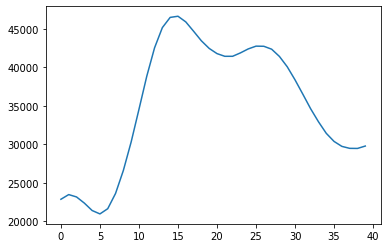

In [71]:
plt.plot(np.sum(temporal_data[0].O_range, axis=(0,1)))
print(temporal_data[0].O_range.shape)

### Visualize aggregated signals

Visualizing what we would expect from combined signals. This is just a quality assurance that we didn't do something real wrong. Signals should look smooth and pretty when SNR is high!

Text(0, 0.5, 'counts')

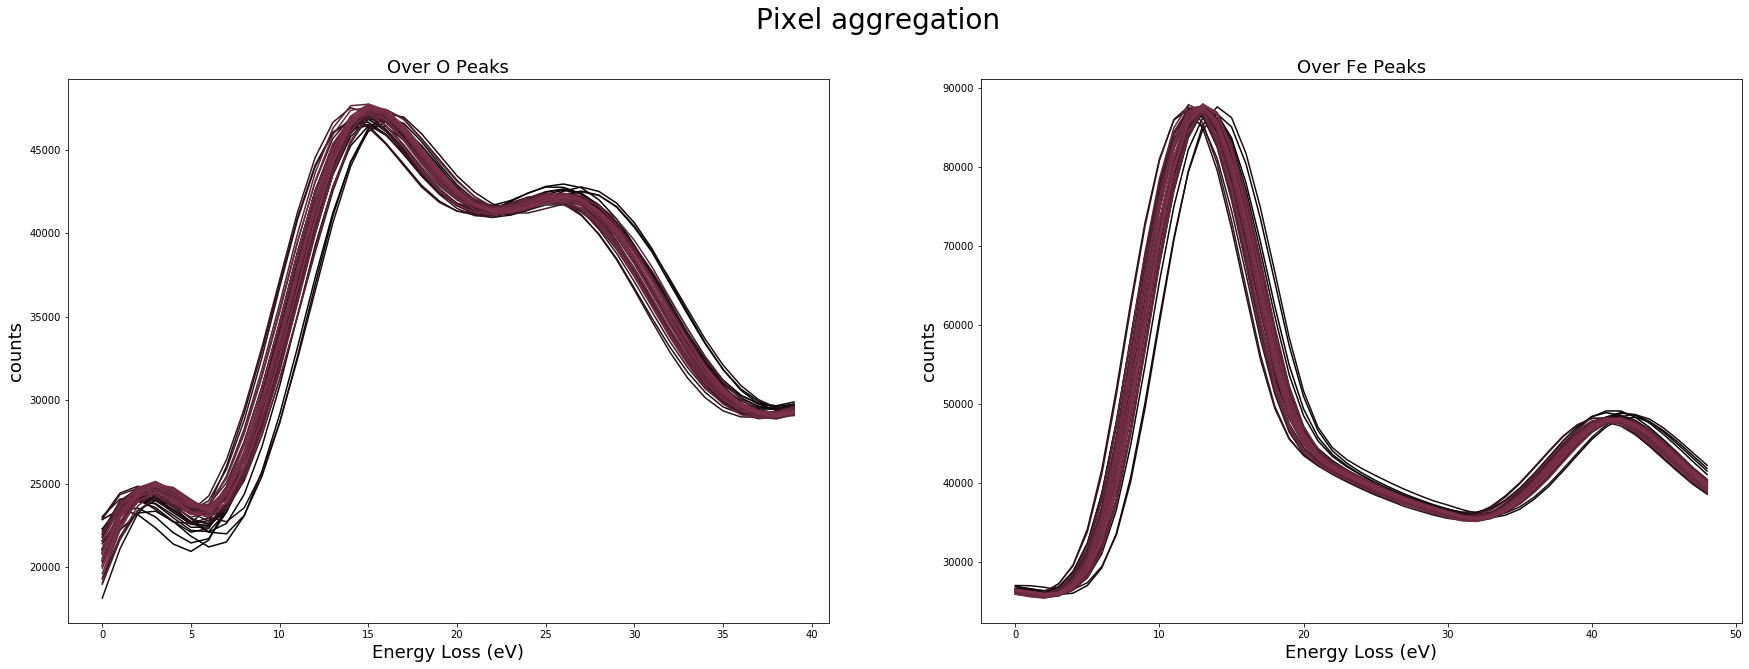

In [72]:
# visualizing raw data

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV

# Plotting aggregared spectra 
g,(ax3,ax4) = plt.subplots(1,2, figsize=(30,10))
for k in range(len(temporal_data)):
    # Plotting aggregation over oxygen range
    ax3.plot(np.sum(temporal_data[k].O_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))
    # Plotting aggregation over Fe range
    ax4.plot(np.sum(temporal_data[k].Fe_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))

# plot configurations
g.suptitle('Pixel aggregation', fontsize=28)

ax3.set_title('Over O Peaks', fontsize=18)
ax3.set_xlabel('Energy Loss (eV)', fontsize=18)
ax3.set_ylabel('counts', fontsize=18)   

ax4.set_title('Over Fe Peaks', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('counts', fontsize=18)  

In [73]:
# rearrange dimension
arrayx = list()
dim = temporal_data[0].O_range.shape
for i in range(len(temporal_data)):
    f = temporal_data[i].O_range.reshape((-1,dim[2]))
    arrayx.append(f)
arrayx = np.array(arrayx).reshape((-1,dim[2]))

In [74]:
arrayx.shape

(196992, 40)

### Setting up RNN autoencoder

In [76]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LeakyReLU
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Conv2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [77]:
def rnn_autoencoder(layer, size, N_encode, 
                    N_decode, embed, 
                    N_steps, lr = 3e-6, drop_frac = 0.1,
                    bidir = False, l1_norm = 1e-4, **kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    N_encode  : numpy, int
        sets the number of encoding layers in the network
    N_decode : numpy, int
        sets the number of decoding layers in the network
    embed : numpy, int
        sets the size of the embedding layer
    N_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidir : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    model = Sequential()
    
    
    
    # wrapper for bidirectional LSTM
    if bidir: wrapper = Bidirectional
    else: wrapper = lambda x: x
        
        
    # builds the first layer
    model.add(wrapper(layer(size, return_sequences=(N_encode > 1),  dropout=drop_frac, input_shape=(N_steps, 1))))

    # builds the encoding layers
    for i in range(1, N_encode):
        model.add(wrapper(layer(size, return_sequences=(i < N_encode - 1), dropout=drop_frac)))

    # builds the embedding layer
    model.add(Dense(embed, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(N_steps))

    # builds the decoding layer
    for i in range(N_decode):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

In [ ]:
def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. 
        It is however limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'
    
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                 verbose=0, save_best_only=True,
                                                 save_weights_only=True, 
                                                 mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data_train), np.atleast_3d(data_train), 
              epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], 
              validation_data=(np.atleast_3d(data_test), np.atleast_3d(data_test)))

In [111]:
# construct a model
model3 = rnn_autoencoder(LSTM, 40, 4, 4, 8, 40)

In [125]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_134 (LSTM)              (None, 40, 40)            6720      
_________________________________________________________________
lstm_135 (LSTM)              (None, 40, 40)            12960     
_________________________________________________________________
lstm_136 (LSTM)              (None, 40, 40)            12960     
_________________________________________________________________
lstm_137 (LSTM)              (None, 40)                12960     
_________________________________________________________________
encoding (Dense)             (None, 8)                 328       
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 40, 8)             0         
_________________________________________________________________
lstm_138 (LSTM)              (None, 40, 40)           

### Training RNN Autoencoder

In [129]:
# set learning rate and compile model
lr = 5e-5
model3.compile(Adam(lr), loss='mse')

In [ ]:
folder_name = 'rnn_auto_deep2_checkpoints'
train_model(model3, arrayx, arrayx, folder_name, epochs=50, batch_size=400)

Train on 196992 samples, validate on 196992 samples
Epoch 1/50
196992/196992 [==============================] - 131s 666us/step - loss: 0.7699 - val_loss: 0.5479
Epoch 2/50
196800/196992 [============================>.] - ETA: 0s - loss: 0.7555

### <span style="color:blue"> Training may take a few days depending on epochs. </span>
    At this point, just let the training run in the background. 
    Go to the next notebook to analyze the trained results.

## Load model

In [ ]:
# load weights
folder_name = 'rnn_auto_checkpoints'
model3.load_weights(folder_name+"/weights.29-0.19090288.hdf5")

# Compile model (required to make predictions)
lr = 5e-3
model3.compile(Adam(lr), loss='mse')

## Make Prediction

In [33]:
test = arrayx[:12768]
test.shape

(12768, 60)

In [34]:
predict = model3.predict(np.atleast_3d(test))

In [35]:
predict.shape

(12768, 60, 1)

Text(0.5, 0.98, 'Spectra Prediction - RNN Autoencoder (LSTM, 120, 6, 6, 30, 120)')

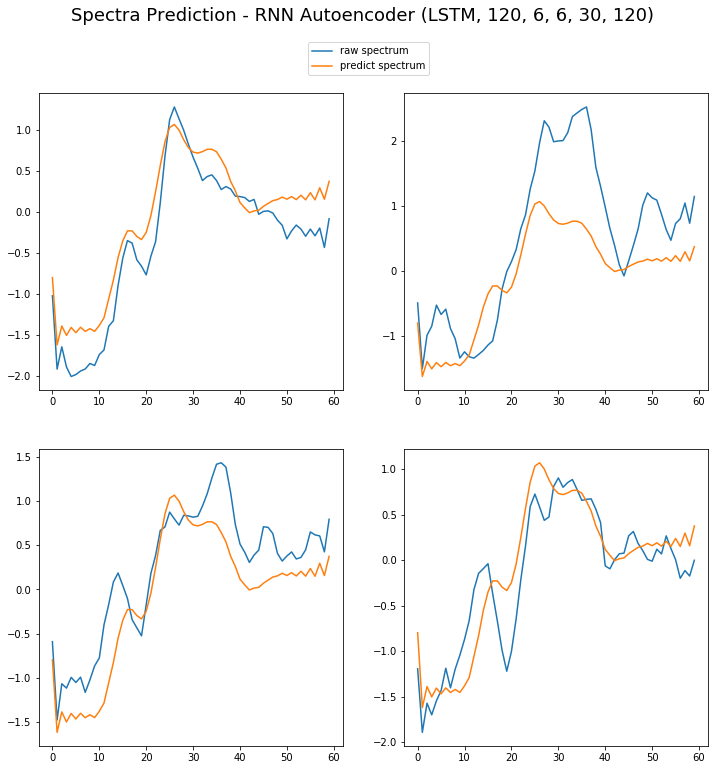

In [39]:
# Plotting Spectra Predictions (randomized for 36 spectra)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
from sklearn import preprocessing
#y1_norm = preprocessing.normalize(x_test)
#y2_norm = preprocessing.normalize(y_predict.reshape(-1,128))
y1_norm = test
y2_norm = predict.reshape(-1,60)
axs.reshape(-1)
for i in range (0,2):
    for j in range(0,2):
        w = np.random.randint(0, y2_norm.shape[0])
        ax = axs[i,j]
        ax.plot(y1_norm[w], label="raw spectrum") 
        ax.plot(y2_norm[w], label="predict spectrum") 
plt.legend(bbox_to_anchor=(.1, 2.39), bbox_transform=ax.transAxes)
fig.suptitle("Spectra Prediction - RNN Autoencoder (LSTM, 120, 6, 6, 30, 120)", fontsize =18)

In [40]:
def get_ith_layer_output(model, X, i, mode='test'):
    """
    Computes the activations of a specific layer
    see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'
    
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
        
    Returns
    -------
    layer_output : float
        array containing the output from layer i of the network
    """
    # computes the output of the ith layer
    get_ith_layer = backend.function([model.layers[0].input, 
                                            backend.learning_phase()], 
                                           [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode == 'test' else 1])[0]

    return layer_output

In [41]:
activation = get_ith_layer_output(model3, np.atleast_3d(test), 12)

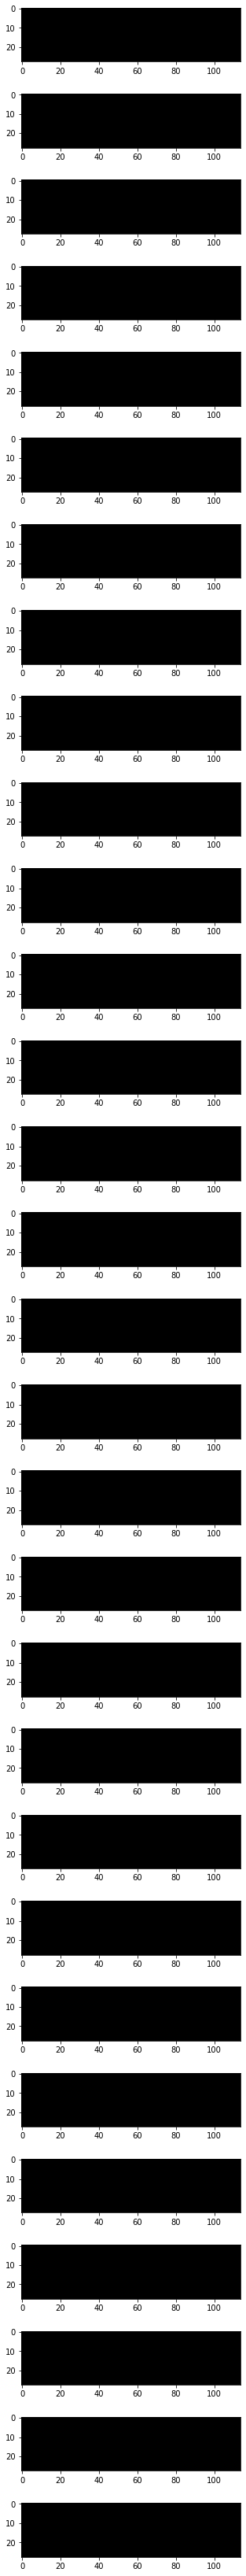

In [42]:
actv = activation.reshape(4,28,114,30)
fig, axs = plt.subplots(30, 1, figsize=(5, 60))
for k in range(30):
    ax = axs[k]
    ax.imshow(actv[3,:,:,k])

In [ ]:
# Sets what object to export
printing = {  # exports eps vector graphics (note these files can be large)
    'EPS': False,
    # exports png files
    'PNG': False,
    # prints image series (note this can take some time)
    'all_figures': False,
    # generates movies (note this can take some time)
    'movies': False,
    # resolution of the images
    'dpi': 300}

In [ ]:
# sets the plotting format
plot_format = {
    # adds scalebar to image
    'add_scalebar': True,
    # sets the dimensions for the scalebar [(size of image),(size of scalebar)]
    'scalebar': [2000, 500],
    # selects if the image will be rotated
    'rotation': False,
    # selects the rotation angle of the image
    'angle': 60.46,
    # sets the fraction of the image to crop
    'frac_rm': 0.17765042979942694,
    # sets the resolution of the image
    'dpi': 300,
    # sets the default colormap
    'color_map': 'viridis',
    # sets if color bars should be added
    'color_bars': True}

In [ ]:
import _archive.JoshCodes.viz.plot as viz_plot

In [ ]:
# plots the embedding maps
_ = viz_plot.embedding_maps(activation,
                             printing,
                             plot_format,
                             'autoencoder/',
                             filename='./embeddings')
